# What things are included in this Kernel ?

- Problem Statment and the Analysis of the Problem Statment
- Data Understanding
- Designing the Model
- Validation And Analysis
    - Metrics
    - Prediction and Activation Visualizations
    - ROC AND AUC
- Submission

1
#a). Problem Statment
- Task - The problem is mainly a BINARY IMAGE CLASSIFICATION PROBLEM. The Problem focuses on identifying the presence of metastases from a 96 * 96 digital histopathology images
- Metric Evaluation - Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.
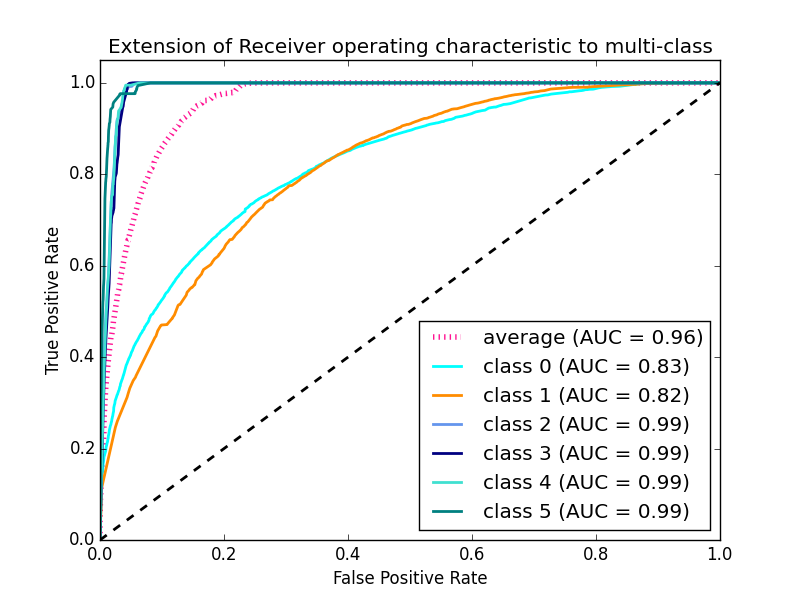

#b). Analysis of the problem Statment
What Exactly the problem statment conveys to us?
1. The problem deals with the Binary Classification of the Image that has a shape of 96px * 96px. It involves identifying the metastases from the 96px * 96px digital histapathology images.
2. One key challenge is that the metastases can be as small as single cells in a large area of tissue.

The Histopathological Images:
About the Domain:
I made some notes about the following terminologies :

- Histopathology
- Lymphocytes
- Lymph Nodes


So, let us see some of the biological terminologies involved
1. Histopathology - Histopathology is the diagnosis and study of diseases of the tissues, and involves examining tissues and/or cells under a microscope. Histopathologists are responsible for making tissue diagnoses and helping clinicians manage a patient's care.
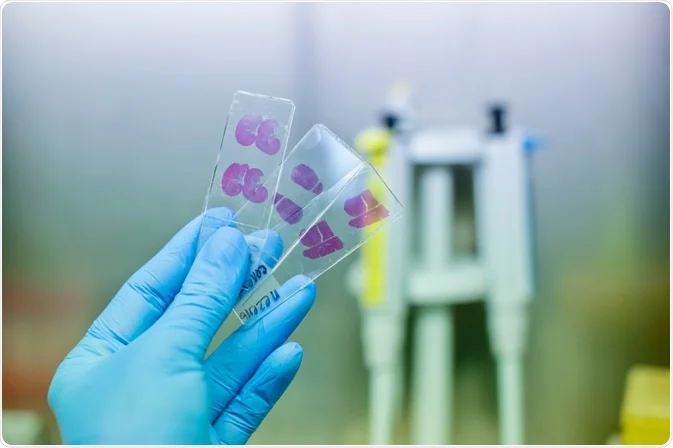


2. Lymphocytes - Lymphocytes are white blood cells that are also one of the body's main types of immune cells. They are made in the bone marrow and found in the blood and lymph tissue. The immune system is a complex network of cells known as immune cells that include lymphocytes.
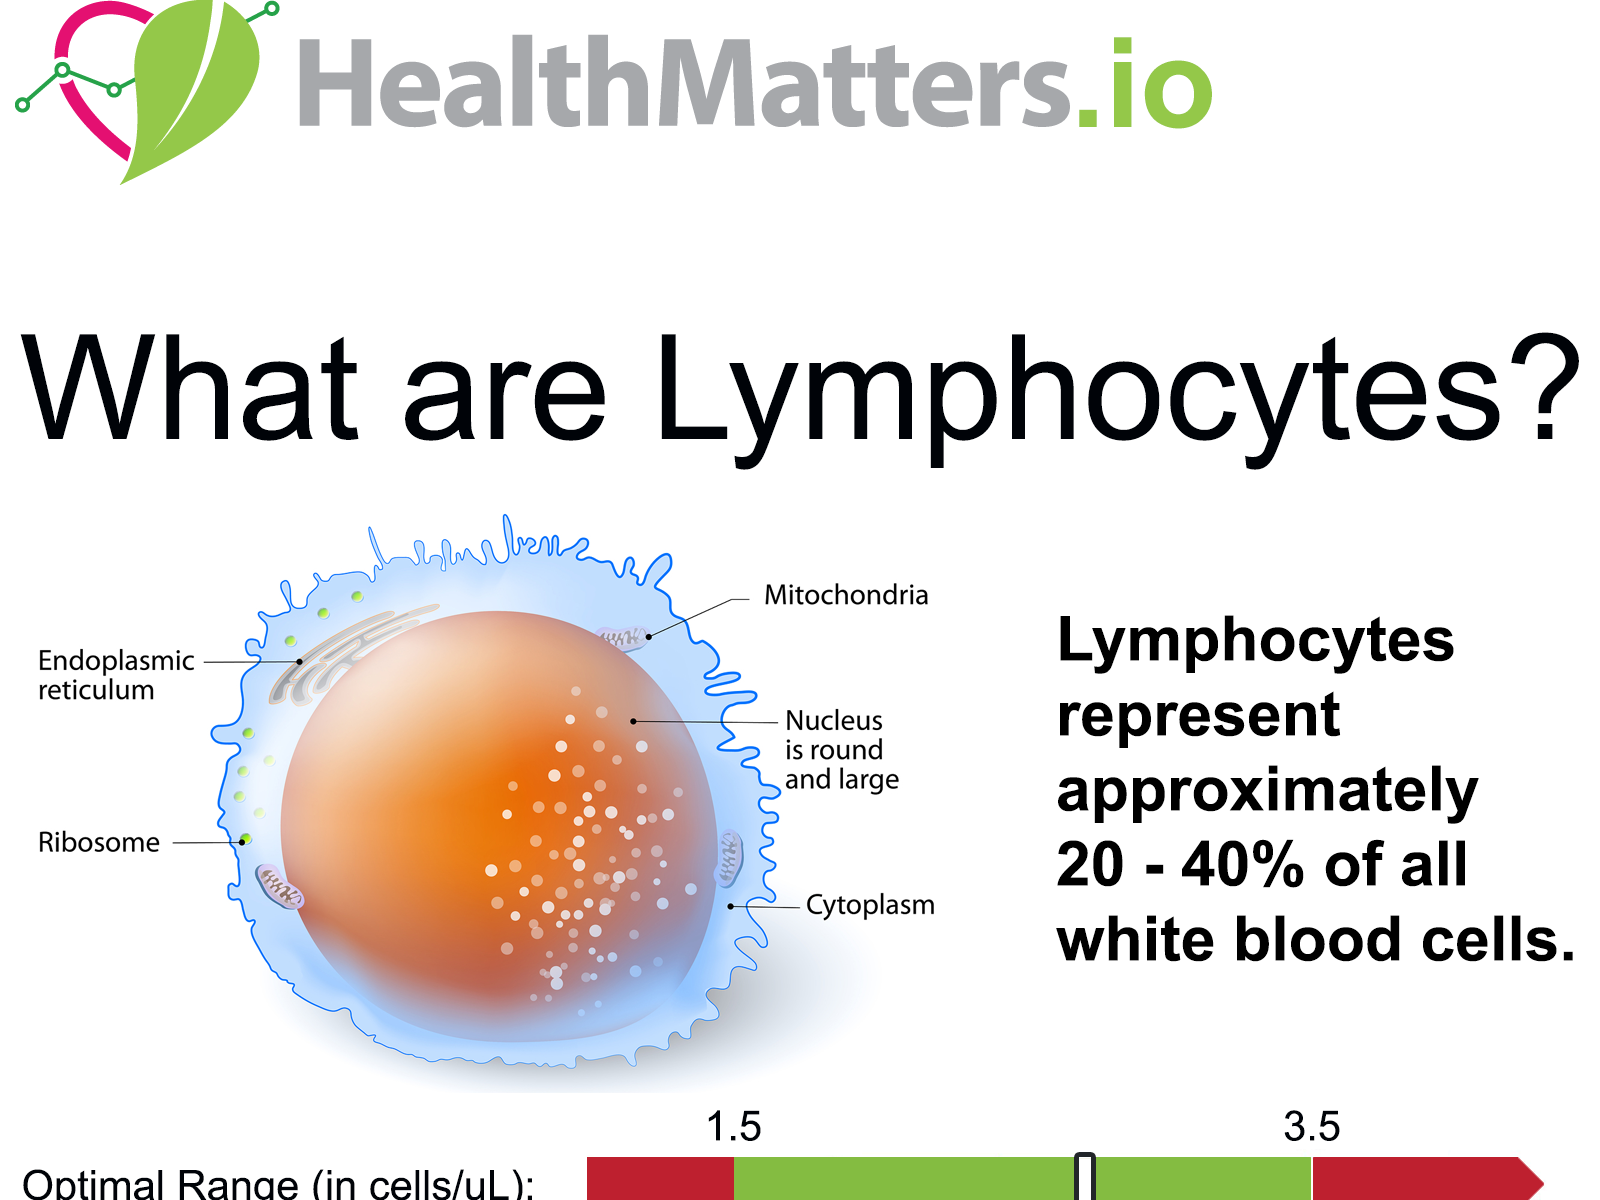

3. Lymph Nodes- Lymph nodes are small lumps of tissue that contain white blood cells, which fight infection. They filter lymph fluid, which is composed of fluid and waste products from your body tissues. Lymph nodes also help activate your immune system if you have an infection.
So, now let us dive into the domain which involves Data Collection:
- The data that is provided to us for classification are the histopathological images. These images are glass slide microscope images of lymph nodes that are stained with hematoxylin and eosin (H&E).
- Hematoxylin and eosin (H&E) is the most widely used stain in histology and allows localization of nuclei and extracellular proteins. Hematoxylin, not a dye itself, produces the blue Hematin via an oxidation reaction with nuclear histones causing nuclei to show blue.
- Typically nuclei are stained blue, whereas cytoplasm and extracellular parts in various shades of pink.
- Lymph nodes are small glands that filter the fluid in the lymphatic system and they are the first place a breast cancer is likely to spread.
- Histological assessment of lymph node metastases is part of determining the stage of breast cancer in TNM classification which is a globally recognized standard for classifying the extent of spread of cancer.

#2. Data Understanding
- The dataset contains the histopathological Images, each image is 96px * 96px.

- A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

- Kaggle says that : 'The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.'

- Also, one of the hing is that the problem states that the training Data contains 50/50 Images of both the labels i.e. the training contains equal proportion of both the labels, however on analysis it was found to be nearly equal to 60/40, which we will consider while we design the model

- **IS DATA RELEVANT TO THE PROBLEM ?**
- This dataset is a combination of two independent datasets collected in Radboud University Medical Center (Nijmegen, the Netherlands), and the University Medical Center Utrecht (Utrecht, the Netherlands). The slides are produced by routine clinical practices and a trained pathologist would examine similar images for identifying metastases.

- So, now let us move forward to design our model



#3. Designing the Model (Coding Part)

In [ ]:
# --- Install OpenCV for Colab ---
!pip install opencv-python-headless --quiet

# --- Reproducibility ---
from numpy.random import seed
seed(101)
import tensorflow as tf
tf.random.set_seed(101)

# --- Base imports ---
import pandas as pd
import numpy as np
import os
import cv2   # Now works

# --- TensorFlow / Keras ---
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# --- Sklearn ---
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# --- Utilities ---
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# Setting Some Pre-Requisites
IMAGE_SIZE=96
IMAGE_CHANNELS=3
SAMPLE_SIZE=80000         # We will be training 80,000 samples from each label

In [ ]:
!pip install gdown

import os
import gdown
import zipfile

# ======================
# Create directories
# ======================
os.makedirs("/train", exist_ok=True)
os.makedirs("/test", exist_ok=True)
os.makedirs("/tmp", exist_ok=True)

# ======================
# Google Drive file IDs
# ======================
files = {
    "sample_submission.csv.zip": "1D-nHcLvv2z655FrJID1URVSP-5a_OqET",
    "test.zip": "15E0GKKa3kxnQGpK9b2kSDax1vJpcPW_h",
    "train_labels.csv.zip": "1MRJ43p4NVheZlCKwphl1Gom5kqzdCvNb",
    "train.zip": "1swT5y9vkrj9KMFW-88aN9mHUAej51kl1",
}

# ======================
# Download all files
# ======================
for filename, file_id in files.items():
    url = f"https://drive.google.com/uc?id={file_id}"
    output_path = f"/tmp/{filename}"
    print(f"\nDownloading {filename} ...")
    gdown.download(url, output_path, quiet=False)

# ======================
# Unzip CSV ZIP files to /tmp
# ======================
print("\nUnzipping sample_submission.csv.zip ...")
with zipfile.ZipFile("/tmp/sample_submission.csv.zip", "r") as z:
    z.extractall("/tmp")

print("Unzipping train_labels.csv.zip ...")
with zipfile.ZipFile("/tmp/train_labels.csv.zip", "r") as z:
    z.extractall("/tmp")

# ======================
# Unzip train and test image datasets
# ======================
print("\nUnzipping train.zip → /train ...")
with zipfile.ZipFile("/tmp/train.zip", "r") as z:
    z.extractall("/train")

print("Unzipping test.zip → /test ...")
with zipfile.ZipFile("/tmp/test.zip", "r") as z:
    z.extractall("/test")

Downloading...
From: https://drive.google.com/uc?id=1D-nHcLvv2z655FrJID1URVSP-5a_OqET
To: /tmp/sample_submission.csv.zip
100%|██████████| 1.40M/1.40M [00:00<00:00, 143MB/s]


Downloading...
From (original): https://drive.google.com/uc?id=15E0GKKa3kxnQGpK9b2kSDax1vJpcPW_h
From (redirected): https://drive.google.com/uc?id=15E0GKKa3kxnQGpK9b2kSDax1vJpcPW_h&confirm=t&uuid=d8312ea5-ec35-40e0-8d87-ed0c8fe06325
To: /tmp/test.zip
100%|██████████| 1.40G/1.40G [00:20<00:00, 67.2MB/s]


Downloading...
From: https://drive.google.com/uc?id=1MRJ43p4NVheZlCKwphl1Gom5kqzdCvNb
To: /tmp/train_labels.csv.zip
100%|██████████| 5.36M/5.36M [00:00<00:00, 191MB/s]


Downloading...
From (original): https://drive.google.com/uc?id=1swT5y9vkrj9KMFW-88aN9mHUAej51kl1
From (redirected): https://drive.google.com/uc?id=1swT5y9vkrj9KMFW-88aN9mHUAej51kl1&confirm=t&uuid=6e7b263a-3494-43d6-a889-2ca8f9490398
To: /tmp/train.zip
100%|██████████| 5.36G/5.36G [01:26<00:00, 62.3MB/s]



Unzipping sample_submission.csv.zip ...
Unzipping train_labels.csv.zip ...

Unzipping train.zip → /train ...
Unzipping test.zip → /test ...


In [ ]:
import os
os.listdir('/tmp')


['sample_submission.csv.zip',
 'language_service.INFO',
 'language_service.c6279da5163f.root.log.INFO.20251130-111805.1355',
 'train.zip',
 'test.zip',
 'test',
 'language_service.c6279da5163f.root.log.INFO.20251130-111904.1662',
 'dap_multiplexer.INFO',
 'debugger_1s6wylr44e',
 'python-languageserver-cancellation',
 'tmux-0',
 'dap_multiplexer.c6279da5163f.root.log.INFO.20251130-111327.111',
 'language_service.c6279da5163f.root.log.INFO.20251130-113130.4780',
 'pyright-4787-jTcjuU4n9HwF',
 'train_labels.csv.zip',
 'sample_submission.csv',
 'initgoogle_syslog_dir.0',
 'train_labels.csv',
 'language_service.c6279da5163f.root.log.INFO.20251130-111807.1377',
 'language_service.c6279da5163f.root.log.INFO.20251130-111346.221',
 'train',
 'language_service.c6279da5163f.root.log.INFO.20251130-111902.1638',
 'language_service.c6279da5163f.root.log.INFO.20251130-113128.4754']

In [ ]:

train_dir = '/tmp/train'
test_dir = '/tmp/test'

print("Train images:", len(os.listdir(train_dir)))
print("Test images:", len(os.listdir(test_dir)))

Train images: 220026
Test images: 57458


In [ ]:
# Creating a dataframe of all the training images

df_data = pd.read_csv('/tmp/train_labels.csv')

# removing this image because it caused a training error previously
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


print(df_data.shape)

(220025, 2)


In [ ]:
df_data['label'].value_counts()

,count
label,
0,130908
1,89117


In [ ]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):

    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """


    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols,
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)
    plt.tight_layout()
    plt.show()

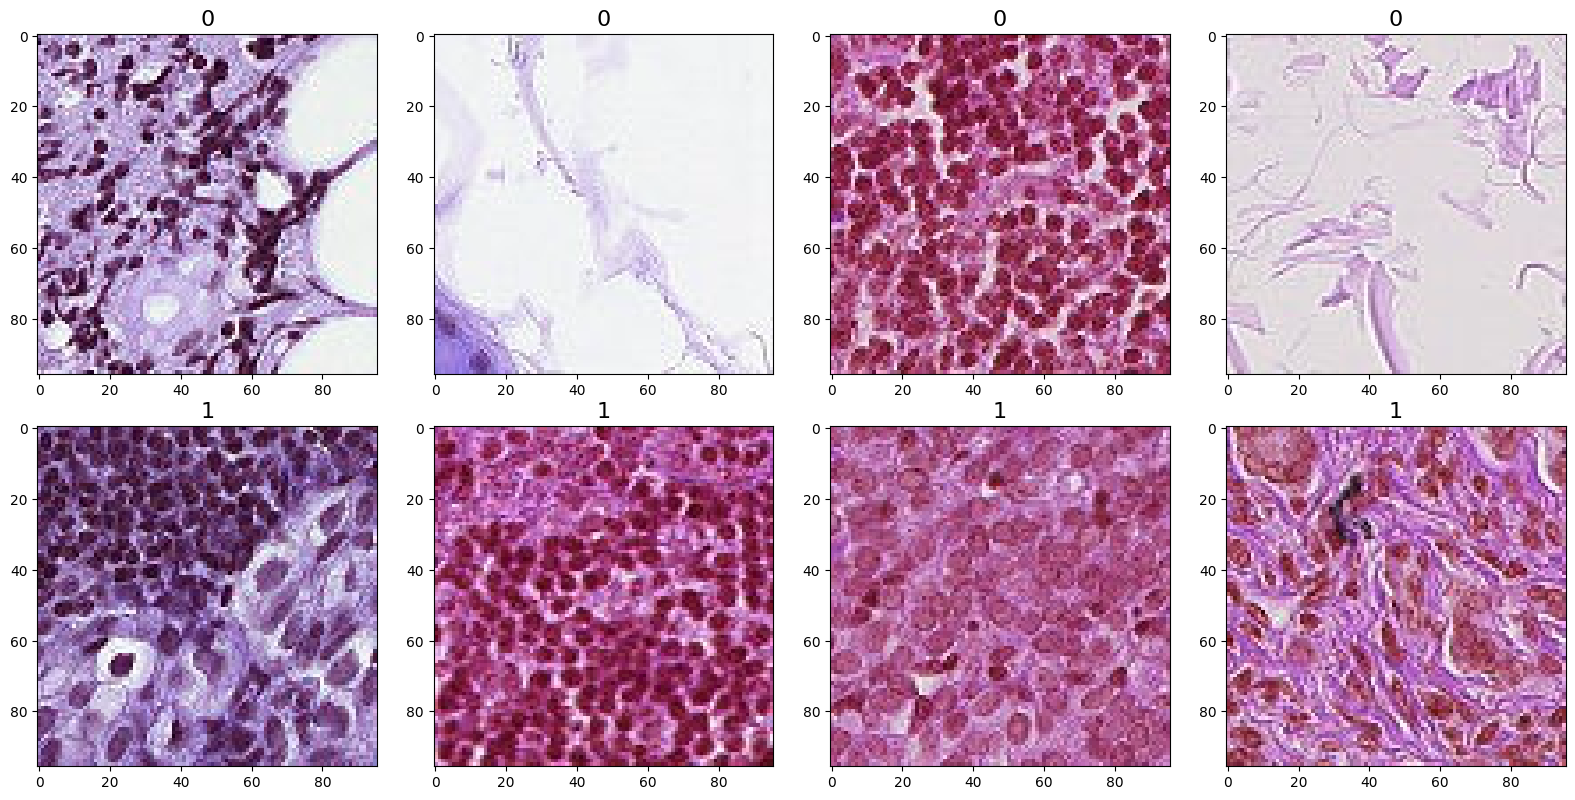

In [ ]:
IMAGE_PATH = '/tmp/train/'

draw_category_images('label',4, df_data, IMAGE_PATH)


In [ ]:
# Create the Train and Validation Sets

df_0=df_data[df_data['label']==0].sample(SAMPLE_SIZE,random_state=101)
df_1=df_data[df_data['label']==1].sample(SAMPLE_SIZE,random_state=101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

,count
label,
0,80000
1,80000


In [ ]:
# Now, for the train-test split

# stratify=y creates a balanced validation set.
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(144000, 2)
(16000, 2)


In [ ]:
import os
import shutil

base_dir = 'base_dir'

# Remove old base_dir if it exists
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
    print(f"Removed existing folder: {base_dir}")

# Now create the base_dir and subfolders
os.mkdir(base_dir)

# Train and validation directories
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(train_dir)
os.mkdir(val_dir)

# Subfolders for classes inside train_dir
os.mkdir(os.path.join(train_dir, 'a_no_tumor_tissue'))
os.mkdir(os.path.join(train_dir, 'b_has_tumor_tissue'))

# Subfolders for classes inside val_dir
os.mkdir(os.path.join(val_dir, 'a_no_tumor_tissue'))
os.mkdir(os.path.join(val_dir, 'b_has_tumor_tissue'))


Removed existing folder: base_dir


In [ ]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['a_no_tumor_tissue', 'b_has_tumor_tissue']

In [ ]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

In [ ]:
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])



# Transfer the train images

for image in train_list:

    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']

    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'

    # source path to image
    src = os.path.join('/tmp/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:

    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']

    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'


    # source path to image
    src = os.path.join('/tmp/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [ ]:
print(len(os.listdir('base_dir/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/train_dir/b_has_tumor_tissue')))

72000
72000


In [ ]:
print(len(os.listdir('base_dir/val_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/val_dir/b_has_tumor_tissue')))

8000
8000


In [ ]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '/tmp/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [ ]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 39, 39, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,661,186 (6.34 MB)

 Trainable params: 1,661,186 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
print(val_gen.class_indices)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}


In [ ]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.00001)
callbacks_list = [checkpoint, reduce_lr]

train_steps = int(np.ceil(num_train_samples / train_batch_size))
val_steps   = int(np.ceil(num_val_samples / val_batch_size))
history = model.fit(train_gen, steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)


Epoch 1/20
14399/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7509 - loss: 0.4967

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_acc available.
  if self._should_save_model(epoch, batch, logs, filepath):


14400/14400 ━━━━━━━━━━━━━━━━━━━━ 294s 20ms/step - accuracy: 0.7509 - loss: 0.4967 - val_accuracy: 0.8124 - val_loss: 0.4429 - learning_rate: 1.0000e-04
Epoch 2/20
    3/14400 ━━━━━━━━━━━━━━━━━━━━ 7:14 30ms/step - accuracy: 0.8389 - loss: 0.4403 

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


14397/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8406 - loss: 0.3661

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 233s 16ms/step - accuracy: 0.8406 - loss: 0.3661 - val_accuracy: 0.8024 - val_loss: 0.4312 - learning_rate: 1.0000e-04
Epoch 3/20
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8681 - loss: 0.3101

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 249s 15ms/step - accuracy: 0.8681 - loss: 0.3101 - val_accuracy: 0.8321 - val_loss: 0.3712 - learning_rate: 1.0000e-04
Epoch 4/20
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8836 - loss: 0.2768

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 218s 15ms/step - accuracy: 0.8836 - loss: 0.2768 - val_accuracy: 0.9046 - val_loss: 0.2352 - learning_rate: 1.0000e-04
Epoch 5/20
14399/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8980 - loss: 0.2500

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 224s 16ms/step - accuracy: 0.8980 - loss: 0.2500 - val_accuracy: 0.8780 - val_loss: 0.2826 - learning_rate: 1.0000e-04
Epoch 6/20
14399/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9052 - loss: 0.2368

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 217s 15ms/step - accuracy: 0.9052 - loss: 0.2368 - val_accuracy: 0.9094 - val_loss: 0.2197 - learning_rate: 1.0000e-04
Epoch 7/20
14397/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9092 - loss: 0.2269

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 216s 15ms/step - accuracy: 0.9092 - loss: 0.2269 - val_accuracy: 0.9224 - val_loss: 0.1988 - learning_rate: 1.0000e-04
Epoch 8/20
14398/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9150 - loss: 0.2126

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 216s 15ms/step - accuracy: 0.9150 - loss: 0.2126 - val_accuracy: 0.9252 - val_loss: 0.1966 - learning_rate: 1.0000e-04
Epoch 9/20
14397/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9178 - loss: 0.2065

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 217s 15ms/step - accuracy: 0.9178 - loss: 0.2065 - val_accuracy: 0.9274 - val_loss: 0.1886 - learning_rate: 1.0000e-04
Epoch 10/20
14397/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9235 - loss: 0.1960

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 268s 16ms/step - accuracy: 0.9235 - loss: 0.1960 - val_accuracy: 0.9204 - val_loss: 0.1989 - learning_rate: 1.0000e-04
Epoch 11/20
14399/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9241 - loss: 0.1939

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 220s 15ms/step - accuracy: 0.9241 - loss: 0.1939 - val_accuracy: 0.9324 - val_loss: 0.1820 - learning_rate: 1.0000e-04
Epoch 12/20
14397/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9283 - loss: 0.1841

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 219s 15ms/step - accuracy: 0.9283 - loss: 0.1841 - val_accuracy: 0.9339 - val_loss: 0.1757 - learning_rate: 1.0000e-04
Epoch 13/20
14399/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9294 - loss: 0.1815

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 219s 15ms/step - accuracy: 0.9294 - loss: 0.1815 - val_accuracy: 0.9348 - val_loss: 0.1724 - learning_rate: 1.0000e-04
Epoch 14/20
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9317 - loss: 0.1768

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 220s 15ms/step - accuracy: 0.9317 - loss: 0.1768 - val_accuracy: 0.9273 - val_loss: 0.1881 - learning_rate: 1.0000e-04
Epoch 15/20
14397/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9356 - loss: 0.1674

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 262s 15ms/step - accuracy: 0.9356 - loss: 0.1674 - val_accuracy: 0.9327 - val_loss: 0.1741 - learning_rate: 1.0000e-04
Epoch 16/20
14396/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9374 - loss: 0.1654

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 218s 15ms/step - accuracy: 0.9374 - loss: 0.1654 - val_accuracy: 0.9362 - val_loss: 0.1705 - learning_rate: 1.0000e-04
Epoch 17/20
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9372 - loss: 0.1630

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 263s 15ms/step - accuracy: 0.9372 - loss: 0.1630 - val_accuracy: 0.9361 - val_loss: 0.1729 - learning_rate: 1.0000e-04
Epoch 18/20
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9391 - loss: 0.1581

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 219s 15ms/step - accuracy: 0.9391 - loss: 0.1581 - val_accuracy: 0.9296 - val_loss: 0.1878 - learning_rate: 1.0000e-04
Epoch 19/20
14398/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9406 - loss: 0.1551

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 221s 15ms/step - accuracy: 0.9406 - loss: 0.1551 - val_accuracy: 0.9377 - val_loss: 0.1686 - learning_rate: 1.0000e-04
Epoch 20/20
14399/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9416 - loss: 0.1528

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 224s 16ms/step - accuracy: 0.9416 - loss: 0.1528 - val_accuracy: 0.9353 - val_loss: 0.1699 - learning_rate: 1.0000e-04


In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'compile_metrics']

In [ ]:

val_loss, val_acc = \
model.evaluate(test_gen,
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

16000/16000 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - accuracy: 0.9371 - loss: 0.1700
val_loss: 0.16985636949539185
val_acc: 0.9353125095367432


<Figure size 640x480 with 0 Axes>

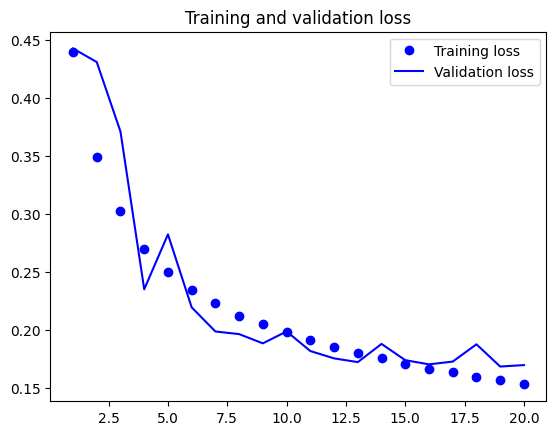

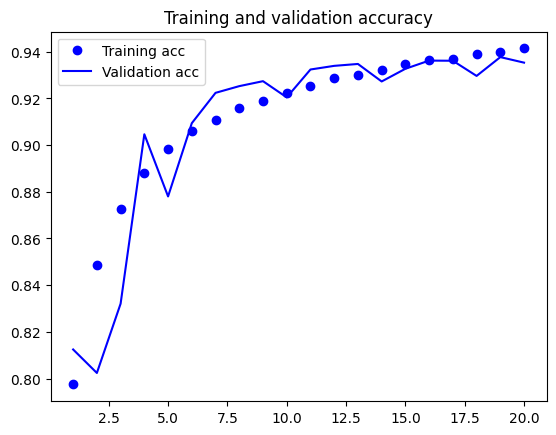

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#4. Validation and Analysis
- Metrics
- Prediction and Activation Visualizations
- ROC and AUC

In [ ]:
predictions = model.predict(test_gen, steps=len(df_val), verbose=1)

16000/16000 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step


In [ ]:
predictions.shape

(16000, 2)

In [ ]:
# This is how to check what index keras has internally assigned to each class.
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

In [ ]:
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.999957,0.000043
1,0.999862,0.000138
2,0.999928,0.000072
3,0.541896,0.458104
4,0.999649,0.000351


In [ ]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_tumor_tissue']

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)


np.float64(0.9821148203125001)

In [ ]:

test_labels = test_gen.classes
test_labels.shape

(16000,)

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
# Print the label associated with each class
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
ConfusionMatrixDisplay.from_predictions


<bound method ConfusionMatrixDisplay.from_predictions of <class 'sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay'>>

In [ ]:
# Delete base_dir and it's sub folders to free up disk space.

shutil.rmtree('base_dir')
#[CREATE A TEST FOLDER DIRECTORY STRUCTURE]

# We will be feeding test images from a folder into predict_generator().
# Keras requires that the path should point to a folder containing images and not
# to the images themselves. That is why we are creating a folder (test_images)
# inside another folder (test_dir).

# test_dir
    # test_images

# create test_dir
test_dir = 'test_dir'
os.mkdir(test_dir)

# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)
# check that the directory we created exists
os.listdir('test_dir')

['test_images']

In [ ]:
test_list = os.listdir('/tmp/test')

for image in test_list:

    fname = image

    # source path to image
    src = os.path.join('/tmp/test', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
# check that the images are now in the test_images
# Should now be 57458 images in the test_images folder

len(os.listdir('test_dir/test_images'))

57458

In [ ]:
test_path ='test_dir'


# Here we change the path to point to the test_images folder.

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [ ]:
num_test_images = 57458



predictions = model.predict(test_gen, steps=num_test_images, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 179s 3ms/step


In [ ]:
len(predictions)

57458

In [ ]:
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.000006,0.999994
1,0.000047,0.999953
2,0.000755,0.999245
3,0.999981,0.000019
4,0.999912,0.000088


In [ ]:
# This outputs the file names in the sequence in which
# the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names
0,0.000006,0.999994,test_images/00006537328c33e284c973d7b39d340809...
1,0.000047,0.999953,test_images/0000ec92553fda4ce39889f9226ace43ca...
2,0.000755,0.999245,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...
3,0.999981,0.000019,test_images/000253dfaa0be9d0d100283b22284ab2f6...
4,0.999912,0.000088,test_images/000270442cc15af719583a8172c87cd2bd...


In [ ]:
def extract_id(x):

    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]

    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names,id
0,0.000006,0.999994,test_images/00006537328c33e284c973d7b39d340809...,00006537328c33e284c973d7b39d340809f7271b
1,0.000047,0.999953,test_images/0000ec92553fda4ce39889f9226ace43ca...,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.000755,0.999245,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.999981,0.000019,test_images/000253dfaa0be9d0d100283b22284ab2f6...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.999912,0.000088,test_images/000270442cc15af719583a8172c87cd2bd...,000270442cc15af719583a8172c87cd2bd9c7746


In [ ]:
y_pred = df_preds['has_tumor_tissue']

# get the id column
image_id = df_preds['id']

**Confusion Matrix**

#5.Submission

In [ ]:
submission = pd.DataFrame({'id':image_id,
                           'label':y_pred,
                          }).set_index('id')

submission.to_csv('patch_preds.csv', columns=['label'])
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.999994
0000ec92553fda4ce39889f9226ace43cae3364e,0.999953
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.999245
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.000019
000270442cc15af719583a8172c87cd2bd9c7746,0.000088


#Confusion Matrix

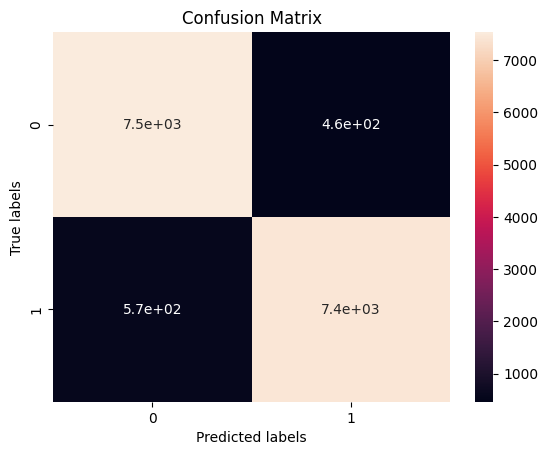

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');